In [20]:
# Parameters
MESH_DENSITY = 5
TIME_STEP_LENGTH = 0.01
N_TIME_STEPS = 100

INLET_VELOCITY = 1.0

# Fluid properties
DENSITY = 1.0
VISCOSITY = 0.01


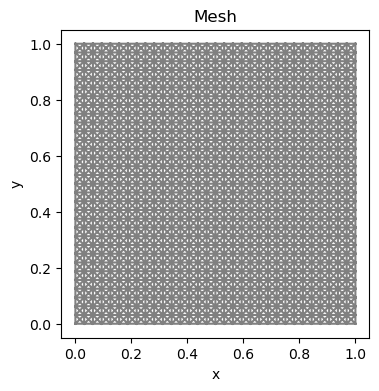

4096


In [21]:
import fenics as fe
import mshr as ms
import matplotlib.pyplot as plt

# Create the mesh
# box = ms.Rectangle(fe.Point(0.0, 0.0), fe.Point(1.0, 1.0))
# hole = ms.Rectangle(fe.Point(0.2,0.4),fe.Point(0.8,0.6)) # 

# domain = box 
# domain -= ms.Rectangle(fe.Point(0.4,0.6),fe.Point(0.6,1.1))
# domain -= ms.Rectangle(fe.Point(0.4,-0.1),fe.Point(0.6,0.4))

# mesh = ms.generate_mesh(domain, MESH_DENSITY)
mesh = fe.UnitSquareMesh(MESH_DENSITY,MESH_DENSITY,'crossed')
# mesh = fe.Mesh('./snake_hole.xml')

fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlabel('x')
ax.set_ylabel('y')
fe.plot(mesh, title='Mesh')
plt.show()

print(mesh.num_cells())

In [22]:
# Define the function spaces

# Taylor-Hood Elements. The order of the function space for the pressure has
# to be one order lower than for the velocity
velocity_function_space = fe.VectorFunctionSpace(mesh, "Lagrange", 2)
pressure_function_space = fe.FunctionSpace(mesh, "Lagrange", 1)

# Define the trial and test functions
u_trial = fe.TrialFunction(velocity_function_space)
p_trial = fe.TrialFunction(pressure_function_space)
v_test = fe.TestFunction(velocity_function_space)
q_test = fe.TestFunction(pressure_function_space)

In [23]:
# Define the Boundary Condition
def top_boundary(x, on_boundary): return on_boundary and fe.near(x[1], 1.0)
def bottom_boundary(x, on_boundary): return on_boundary and fe.near(x[1], 0.0)
def left_boundary(x, on_boundary): return on_boundary and fe.near(x[0], 0.0)
def right_boundary(x, on_boundary): return on_boundary and fe.near(x[0], 1.0)

#inflow = fe.Constant((INLET_VELOCITY, 0.0))
inflow_sin = fe.Expression(('sin(2*pi*x[0])+1',0.0), degree=2)
inflow_1 = fe.Constant((1.0,0.0))
noslip = fe.Constant((0.0, 0.0))

velocity_boundary_conditions = [
fe.DirichletBC(velocity_function_space, noslip, left_boundary),
fe.DirichletBC(velocity_function_space, noslip, right_boundary),
fe.DirichletBC(velocity_function_space, inflow_1, top_boundary),
fe.DirichletBC(velocity_function_space, noslip, bottom_boundary),
]

pressure_boundary_conditions = [
    fe.DirichletBC(pressure_function_space, 0.0 , left_boundary),
    fe.DirichletBC(pressure_function_space, 0.0 , right_boundary),
    fe.DirichletBC(pressure_function_space, 0.0 , top_boundary),
    fe.DirichletBC(pressure_function_space, 0.0 , bottom_boundary)
]

In [24]:
# Define the solution fields involved
u_prev = fe.Function(velocity_function_space) # velocity at previous time step, used for time integration
u_tent = fe.Function(velocity_function_space) # velocity before pressure correction
u_next = fe.Function(velocity_function_space) # velocity after pressure correction, at current time step
p_next = fe.Function(pressure_function_space) # pressure at current time step


In [25]:
# Weak form of the momentum equation
dt = fe.Constant(TIME_STEP_LENGTH)
rho = fe.Constant(DENSITY)
mu = fe.Constant(VISCOSITY)
nu = fe.Constant(VISCOSITY / DENSITY)

momentum_residuum = (
    1.0 / dt * fe.inner(u_trial - u_prev, v_test) * fe.dx
    +
    fe.inner(fe.grad(u_prev) * u_prev, v_test) * fe.dx
    +
    nu * fe.inner(fe.grad(u_trial), fe.grad(v_test)) * fe.dx)

# todo [ ]: what's lhs and rhs?
momentum_lhs = fe.lhs(momentum_residuum)
momentum_rhs = fe.rhs(momentum_residuum)

# Weak form of the pressure poisson problem
pressure_poisson_lhs = fe.inner(fe.grad(p_trial), fe.grad(q_test)) * fe.dx
pressure_poisson_rhs =( - 1.0 / dt * fe.div(u_tent) * q_test * fe.dx)

# Weak form of the velocity update equation
velocity_update_lhs = fe.inner(u_trial, v_test) * fe.dx
velocity_update_rhs = (
    fe.inner(u_tent, v_test) * fe.dx
    -
    dt * fe.inner(fe.grad(p_next), v_test) * fe.dx
)

# Pre-Compute the system matrices A (because they do not greatly change)
momentum_A = fe.assemble(momentum_lhs)
pressure_poisson_A = fe.assemble(pressure_poisson_lhs)
velocity_update_A = fe.assemble(velocity_update_lhs)


In [26]:
# Time loop
from tqdm import tqdm  # for progress bar

for t in tqdm(range(N_TIME_STEPS)):
    # (1) Solve for tentative velocity
    momentum_b = fe.assemble(momentum_rhs)
    [bc.apply(momentum_A, momentum_b) for bc in velocity_boundary_conditions]
    fe.solve(
        momentum_A,
        u_tent.vector(),
        momentum_b,
        "gmres",
        "ilu",
    )
    
    # (2) Solve for the pressure
    pressure_poisson_b = fe.assemble(pressure_poisson_rhs)
    [bc.apply(pressure_poisson_A, pressure_poisson_b)
     for bc in pressure_boundary_conditions]
    fe.solve(
        pressure_poisson_A,
        p_next.vector(),
        pressure_poisson_b,
        "gmres",
        "amg",
    )

    # (3) Correct the velocities to be incompressible
    velocity_update_b = fe.assemble(velocity_update_rhs)
    [bc.apply(momentum_A, momentum_b) for bc in velocity_boundary_conditions]
    fe.solve(
        velocity_update_A,
        u_next.vector(),
        velocity_update_b,
        "gmres",
        "ilu",
    )

    # Advance in time
    u_prev.assign(u_next)


100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


(18624,)


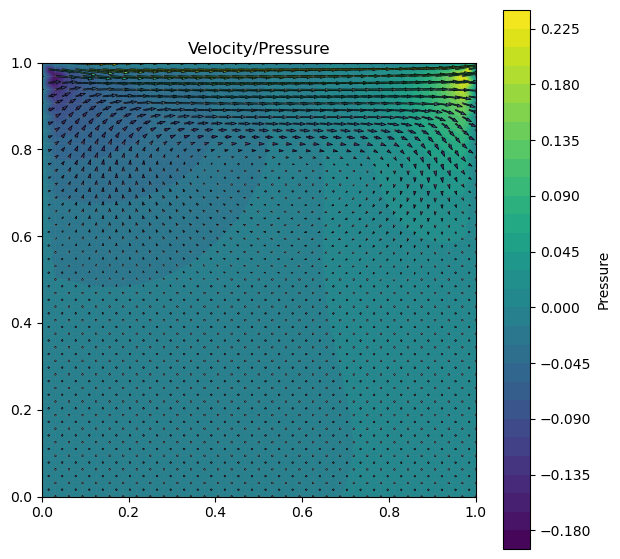

In [34]:
# Plot results
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 7),dpi=100)
pressure_plot = fe.plot(p_next,)# cmap='turbo')
plt.colorbar(pressure_plot, label='Pressure')
velocity_plot = fe.plot(u_next, edgecolor='black',
                        linewidth=0.5, minshaft=1, minlength=1.5,title='Velocity/Pressure')
fe.plot(mesh, linewidth=0.1)

# ax = plt.gca()
# line = ax.lines[0]
# print(line.get_xdata())
# print(li)
